In [1]:
from pathlib import Path
import pandas as pd

# Data folder is one level up from this notebook ("6. Coding and documentation")
DATA = Path("..") / "Data"
task_csv = DATA / "onet_tasks.csv"
isco_xlsx = DATA / "Eurostat_employment_isco.xlsx"

print("DATA:", DATA)
print("Files exist? ->", task_csv.exists(), isco_xlsx.exists())

# Load datasets
task_data = pd.read_csv(task_csv)
isco_data = {f"ISCO{i}": pd.read_excel(isco_xlsx, sheet_name=f"ISCO{i}") for i in range(1, 10)}

print("Loaded", task_csv.name, "shape:", task_data.shape)
for name, df in isco_data.items():
    print(name, "shape:", df.shape)


DATA: ../Data
Files exist? -> True True
Loaded onet_tasks.csv shape: (391, 25)
ISCO1 shape: (40, 11)
ISCO2 shape: (40, 11)
ISCO3 shape: (40, 11)
ISCO4 shape: (40, 11)
ISCO5 shape: (40, 11)
ISCO6 shape: (40, 11)
ISCO7 shape: (40, 11)
ISCO8 shape: (40, 11)
ISCO9 shape: (40, 11)


In [2]:
import pandas as pd

# Compute totals for each country automatically
countries = ["Belgium", "Spain", "Poland"]

totals = {}
for country in countries:
    totals[country] = sum(df[country] for df in isco_data.values())

# Check results
for c, series in totals.items():
    print(c, "length:", len(series))


Belgium length: 40
Spain length: 40
Poland length: 40


In [3]:
import numpy as np
import pandas as pd

# 1) Build one long table from ISCO1..ISCO9 (add 1‑digit ISCO code)
frames = []
for name, df in isco_data.items():           # isco_data came from the 1st cell
    isco_digit = int(name.replace("ISCO", ""))  # "ISCO3" -> 3
    tmp = df.copy()
    tmp["ISCO"] = isco_digit
    frames.append(tmp)

all_data = pd.concat(frames, ignore_index=True)

# 2) Use the totals we already computed to add per‑country shares
countries = ["Belgium", "Spain", "Poland"]
for c in countries:
    # totals[c] is len 40; repeat 9 times to match all_data (9*40 rows)
    all_data[f"total_{c}"] = pd.concat([totals[c]] * 9, ignore_index=True)
    all_data[f"share_{c}"] = all_data[c] / all_data[f"total_{c}"]

# 3) Task data → 1‑digit ISCO means
task_data["isco08_1digit"] = task_data["isco08"].astype(str).str[:1].astype(int)
aggdata = (
    task_data.groupby("isco08_1digit")
    .mean(numeric_only=True)
    .drop(columns=["isco08"], errors="ignore")
)

# 4) Merge employment + task means
combined = all_data.merge(aggdata, left_on="ISCO", right_on="isco08_1digit", how="left")
combined.head()


,TIME,European Union - 28 countries (2013-2020),Belgium,Czechia,Denmark,Spain,Italy,Lithuania,Poland,Finland,...,t_4C3b7,t_4C3d3,t_4C3b8_rev,t_4C1a2l_rev,t_4A4a5_rev,t_4A4a8_rev,t_4A1b2_rev,t_4A3a2_rev,t_4A3b4_rev,t_4A3b5_rev
0,2011-Q1,12850.9,279.0,223.5,57.6,879.8,896.0,120.0,963.5,137.2,...,3.265843,1.518102,1.567,1.208102,3.203343,2.898278,3.102407,3.865861,4.223907,4.270759
1,2011-Q2,12834.2,304.7,226.2,58.2,911.6,897.0,118.9,918.4,135.8,...,3.265843,1.518102,1.567,1.208102,3.203343,2.898278,3.102407,3.865861,4.223907,4.270759
2,2011-Q3,12763.1,348.8,227.3,107.5,881.4,840.1,107.0,913.8,123.5,...,3.265843,1.518102,1.567,1.208102,3.203343,2.898278,3.102407,3.865861,4.223907,4.270759
3,2011-Q4,12668.1,347.9,230.3,74.1,888.2,764.9,107.8,935.9,106.6,...,3.265843,1.518102,1.567,1.208102,3.203343,2.898278,3.102407,3.865861,4.223907,4.270759
4,2012-Q1,12197.3,304.0,231.1,50.6,848.8,762.2,107.5,952.5,102.5,...,3.265843,1.518102,1.567,1.208102,3.203343,2.898278,3.102407,3.865861,4.223907,4.270759


In [4]:
import numpy as np

# Tasks we care about (column names in the CSV)
tasks = ["t_4A2a4", "t_4A2b2", "t_4A4a1"]   # Analyzing Data, Thinking Creatively, Interpreting Meaning
countries = ["Belgium", "Spain", "Poland"]

def weighted_z(x: pd.Series, w: pd.Series) -> pd.Series:
    """Return standardized values (mean 0, sd 1) using weights w."""
    m = np.average(x, weights=w)
    var = np.average((x - m) ** 2, weights=w)
    sd = np.sqrt(var) if var > 0 else np.nan
    return (x - m) / sd

# Create standardized columns for each task × country
for t in tasks:
    for c in countries:
        combined[f"std_{c}_{t}"] = weighted_z(combined[t], combined[f"share_{c}"])

# quick check of the new columns
combined.filter(regex=r"^std_(Belgium|Spain|Poland)_(t_4A2a4|t_4A2b2|t_4A4a1)$").head()


,std_Belgium_t_4A2a4,std_Spain_t_4A2a4,std_Poland_t_4A2a4,std_Belgium_t_4A2b2,std_Spain_t_4A2b2,std_Poland_t_4A2b2,std_Belgium_t_4A4a1,std_Spain_t_4A4a1,std_Poland_t_4A4a1
0,1.283003,1.639543,1.510081,0.941598,1.227219,1.120186,0.931835,1.238556,1.148909
1,1.283003,1.639543,1.510081,0.941598,1.227219,1.120186,0.931835,1.238556,1.148909
2,1.283003,1.639543,1.510081,0.941598,1.227219,1.120186,0.931835,1.238556,1.148909
3,1.283003,1.639543,1.510081,0.941598,1.227219,1.120186,0.931835,1.238556,1.148909
4,1.283003,1.639543,1.510081,0.941598,1.227219,1.120186,0.931835,1.238556,1.148909


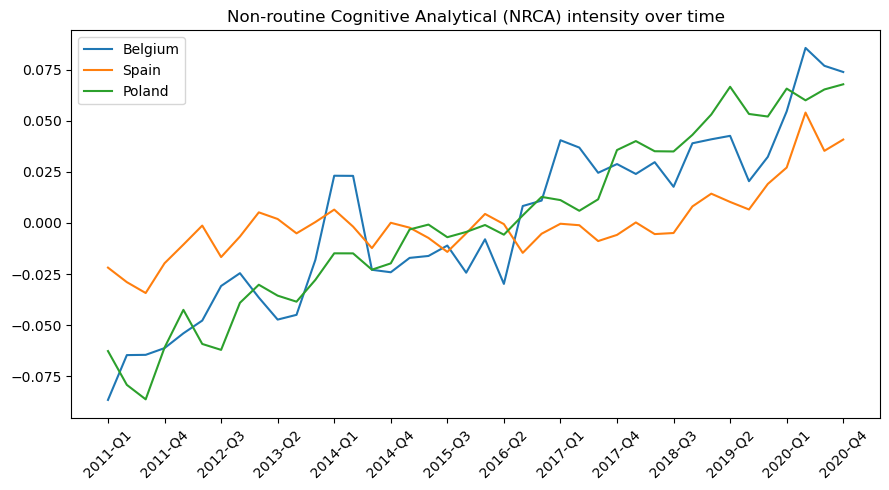

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- inputs we already have ---
countries = ["Belgium", "Spain", "Poland"]
tasks = ["t_4A2a4", "t_4A2b2", "t_4A4a1"]  # the three non‑routine cognitive tasks

# helper: weighted z-standardization (same idea you used above)
def weighted_z(x: pd.Series, w: pd.Series) -> pd.Series:
    m = np.average(x, weights=w)
    var = np.average((x - m) ** 2, weights=w)
    sd = np.sqrt(var) if var > 0 else np.nan
    return (x - m) / sd

# 1) Build NRCA for each country as the sum of its standardized task columns
for c in countries:
    std_cols = [f"std_{c}_{t}" for t in tasks]
    combined[f"{c}_NRCA"] = combined[std_cols].sum(axis=1)

# 2) Standardize NRCA per country using that country’s employment shares as weights
for c in countries:
    combined[f"std_{c}_NRCA"] = weighted_z(combined[f"{c}_NRCA"], combined[f"share_{c}"])

# 3) Country‑level quarterly means (weight by share again)
agg = {}
for c in countries:
    w = combined[f"share_{c}"]
    x = combined[f"std_{c}_NRCA"]
    # multiply by weights then sum by TIME (equivalent to weighted mean)
    tmp = (combined.assign(wx=x * w)
           .groupby("TIME", as_index=False)["wx"].sum())
    tmp.rename(columns={"wx": f"{c}_NRCA_mean"}, inplace=True)
    agg[c] = tmp

# 4) Plot all three with a small loop
plt.figure(figsize=(9, 5))
for c in countries:
    plt.plot(agg[c]["TIME"], agg[c][f"{c}_NRCA_mean"], label=c)
plt.xticks(range(0, len(agg[countries[0]]), 3), agg[countries[0]]["TIME"].iloc[::3], rotation=45)
plt.title("Non‑routine Cognitive Analytical (NRCA) intensity over time")
plt.legend()
plt.tight_layout()
plt.show()
